In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import linsolve

## Sample Covariance matrix

The sample covariance matrix for a $p \times 1$ random vector given $n$ independent observations is given by:

$$Q = \frac{1}{n-1} \Sigma (x_i - \bar{x})(x_i - \bar{x})^T $$

**Properties**:
1. For a gaussian random distribution, the variance is $2\sigma^2$ if the random numbers were drawn with scale$=\sigma$.

2. The sample covariance matrix will *not* have zero off-diagonal terms even though the terms have been drawn independently are not covariant.

3. The off-diagonal terms seem to be proportional to the variance of the variables.

In [2]:
def noise(loc=0,scale=1,size=1):
    return np.random.normal(loc=loc,scale=scale,size=size) + 1j*np.random.normal(loc=loc,scale=scale,size=size)

<IPython.core.display.Javascript object>


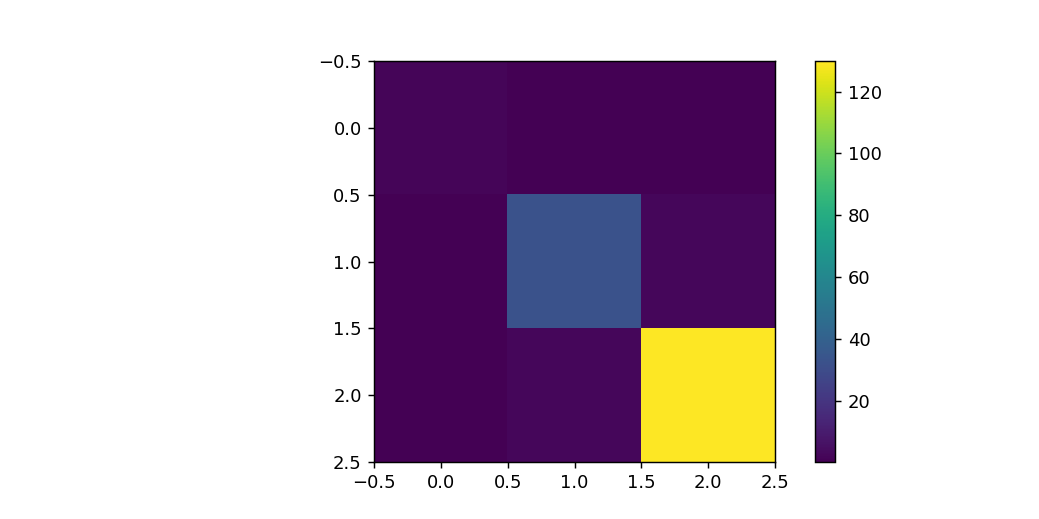

In [3]:
data = np.vstack((noise(scale=1,size=1000),noise(scale=4,size=1000)))
data = np.vstack((data,noise(scale=8,size=1000)))
cov = np.cov(data)

plt.figure(figsize=(8,4))
plt.imshow(np.abs(cov))
plt.colorbar()

# Covariance matrix for Ax=b

For the system of equations represented by $Ax=b$, the covariance matrix is given by the neat formula:

$$Q = (A^TN^{-1}A)^{-1}$$

When the errors are independent (as in our case), the noise covariance matrix drops out and we get:

$$Q = \sigma^2(A^TA)^{-1}$$

In the limit of a large number of solutions for the estimate $\hat{x}$, the sample covariance matrix should equal the above matrix.

$$\Sigma (x_i-\bar{x})(x_i-\bar{x})^T \rightarrow \sigma^2 (A^TA)^{-1}$$

# Logarithmic solution for products

When you have a system of equations involving purely the products of variables, you can solve them by linearlizing with logarithms.

$$xy = 3  \rightarrow \log{x} + \log{y} = \log{3} $$

This becomes more interesting when the variables are complex numbers. The logarithm of a complex number separates the amplitude and phase into the real and imaginary parts when you linearize.

$$x = a + ib = |x|e^{i\phi} = e^{\eta} e^{i\phi} = e^{\eta+i\phi}$$
$$\log{e^{\eta + i\phi}} = \eta + i\phi = \log{|x|} + i\angle{x}$$

So when you are linearizing a system of complex equations, you are naturally solving **two independent systems** of equations- one for the **real or amplitude part** and the other for the **imaginary or phase part** of the variable.

# Example

$$xy = 4i $$
$$xz^* = 6 $$
$$y^*z = 12$$

True solution:

$$x = 1+1j$$
$$y = 2+2j$$
$$z = 3+3j$$

In [4]:
data = {}
data['x*y'] = 4j
data['x*z_'] = 6
data['y_*z'] = 12

<IPython.core.display.Javascript object>


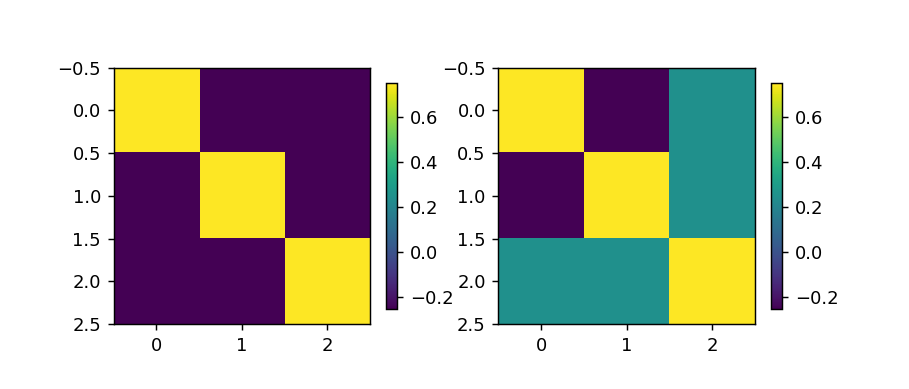

In [5]:
Ar = [[1, 1, 0], [1, 0, 1], [0, 1, 1]]
Ai = [[1, 1, 0], [1, 0, -1], [0, -1, 1]]
plt.figure(figsize=(7,3))
plt.subplot(121)
plt.imshow(np.linalg.inv(np.dot(np.transpose(Ar),Ar)))
plt.colorbar(shrink=0.75)
plt.subplot(122)
plt.imshow(np.linalg.inv(np.dot(np.transpose(Ai),Ai)))
plt.colorbar(shrink=0.75)

In [6]:
# Actual solution
lps = linsolve.LogProductSolver(data)
sol = lps.solve()
for k,v in sol.items():
    print k, np.log(v)

y (1.0397208+0.7853982j)
x (0.3465736+0.7853982j)
z (1.4451858+0.7853982j)


In [7]:
X = np.zeros([1,3])
n = np.zeros([1,3])
Nsim = 2**10
for i in range(Nsim):
    noise_sim = noise(size=3)
    data_sim = {}
    for i,k in enumerate(['x','y','z']):
        data_sim[k] = 100*noise_sim[i] 
    lps = linsolve.LogProductSolver(data_sim)
    sol = lps.solve()
    n = np.vstack((n,noise_sim)) 
    X = np.vstack((X,[sol['x'],sol['y'],sol['z']]))
X = np.transpose(X[1:,:])
n = np.transpose(n[1:,:])

<IPython.core.display.Javascript object>


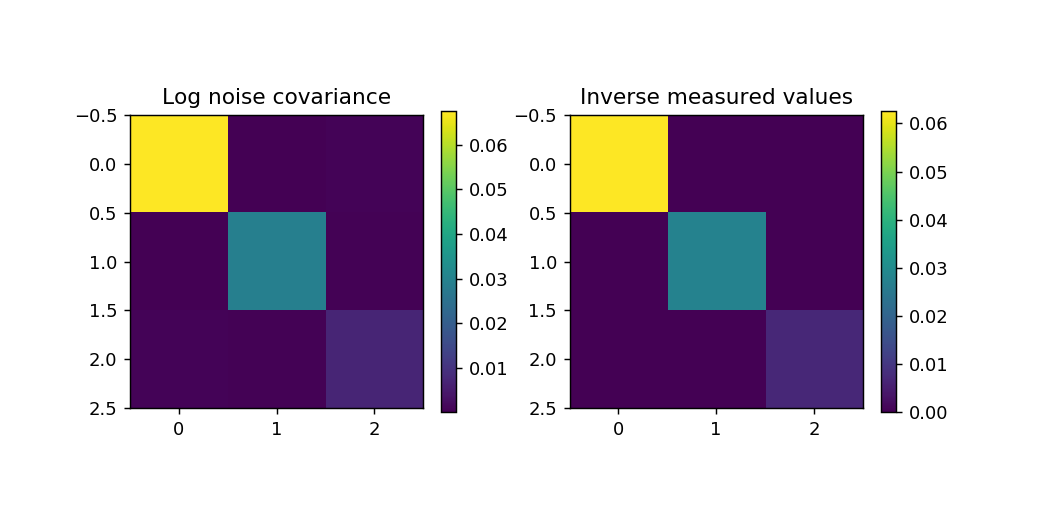

In [8]:
plt.figure(figsize=(8,4))
plt.subplot(121)
plt.title('Log noise covariance')
N = np.cov(np.log(1 + n/[[4j],[6],[12]]))
plt.imshow(np.abs(N)/2)
plt.colorbar(shrink=0.75)

b = [[4j, 0, 0],[0, 6, 0],[0, 0, 12]]
plt.subplot(122)
plt.title('Inverse measured values')
plt.imshow(np.abs(np.linalg.inv(b)**2))
plt.colorbar(shrink=0.75)

# Parameter covariance matrix

The covariance of the estimated parameters, we said, could be derived from the system of linear equations setup to solve for them.

$$\Sigma (x_i-\bar{x})(x_i-\bar{x})^T = (A^T N^{-1}A)^{-1}$$

**But!** The above is true **only when the noise is gaussian.** In our case the noise statistics are not gaussian random since we are taking the log of the gaussian random noise. Hence, these two matrices will differ as we can see below.

<IPython.core.display.Javascript object>


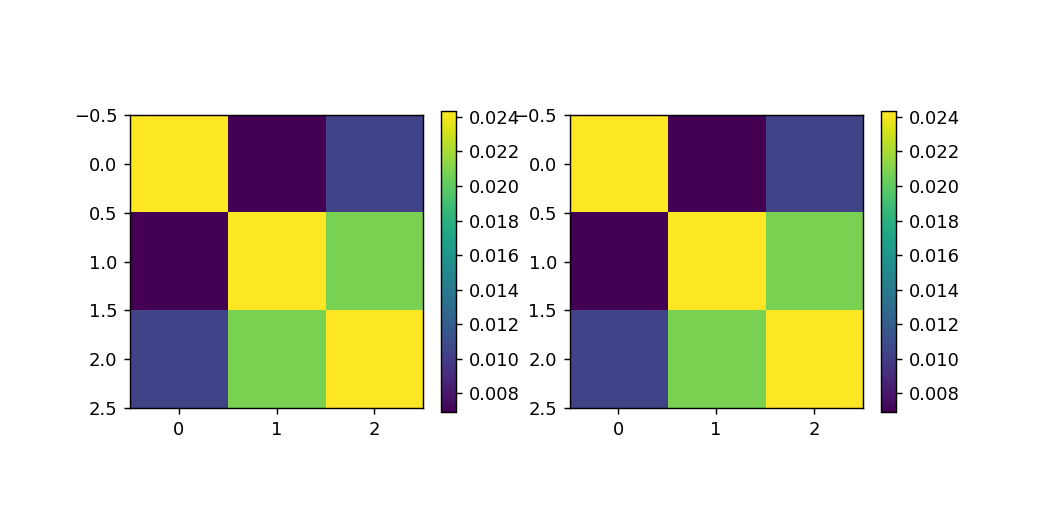

In [9]:
#C = np.linalg.pinv(np.einsum('nm,np,pq->mq',Ar,np.linalg.pinv(N),Ar))
Cr = np.linalg.pinv(np.einsum('nm,np,pq->mq',Ar,np.dot(np.abs(b),np.abs(b)),Ar))
Ci = np.linalg.pinv(np.einsum('nm,np,pq->mq',Ai,np.dot(np.abs(b),np.abs(b)),Ai))
plt.figure(figsize=(8,4))
plt.subplot(121)
plt.imshow(np.abs(Cr))
plt.colorbar(shrink=0.75)
plt.subplot(122)
plt.imshow(np.abs(Ci))
plt.colorbar(shrink=0.75)

<IPython.core.display.Javascript object>


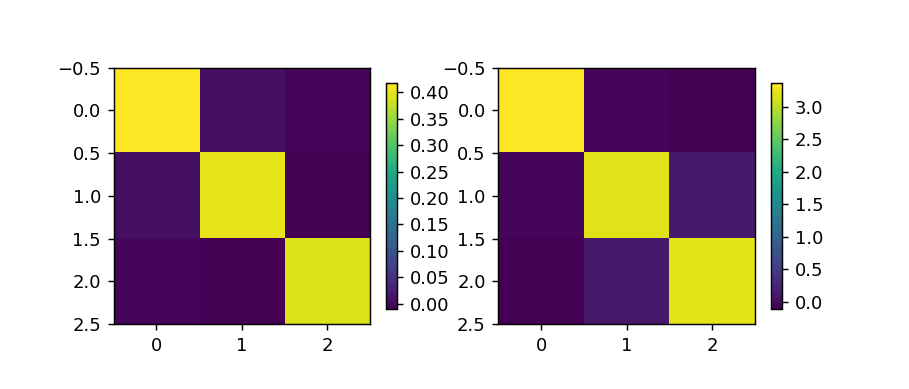

In [10]:
plt.figure(figsize=(7,3))
plt.subplot(121)
plt.imshow(np.cov(np.real(np.log(X))))
plt.colorbar(shrink=0.75)
plt.subplot(122)
plt.imshow(np.cov(np.imag(np.log(X))))
plt.colorbar(shrink=0.75)

# LogCal Solutions

When you have noisy equations of the sort:

$$ 4xi = 12 $$
$$ 2x = -6i $$
$$-5ix^* = 15$$
$$ 3x^* = 9i$$

Does Logcal average over individual solutions to obtain the final value of $x$?

In [24]:
data = {}
coeefs = [4j, 2, -5j, 3]
data[str(coeefs[0])+'*x']   = 12  + 1*noise()
data[str(coeefs[1])+'*x']    = -6j + 1*noise()
data[str(coeefs[2])+'*x_'] = 15 + 1*noise()
data[str(coeefs[3])+'*x_']   = 9j + 1*noise()

In [32]:
data = {}
data['x'] = [[12,1,2]]
data['x*y'] = [[12,1,2]]

In [35]:
lps = linsolve.LogProductSolver(data)
sol = lps.solve()
for k,v in sol.items():
    print k, v

y [[1. 1. 1.]]
x [[12.  1.  2.]]


In [16]:
# Average
(data['(4j)*x']/4j + data['(2)*x']/2 + np.conj(data['(-5j)*x_']/(-5j)) + np.conj(data['(3)*x_']/3))/4

array([0.00862541-3.02638476j])

In [26]:
# Weighted average
(data['(4j)*x']*4j + data['(2)*x']*2 + np.conj(data['(-5j)*x_']*(-5j)) + np.conj(data['(3)*x_']*3))/(-16 + 4 - 25 + 9)

KeyError: '(4j)*x'

In [9]:
# No noise solution
(4j*12 + 2*(-6j) + np.conj(15*(-5j)) + np.conj(3*9j))/(-16 + 4 - 25 + 9)

(-0-3j)

###### 